# Learning objective

The primary goal of this notebook is to perform sensitivity analysis on a system modeled with a three-component Dirichlet distribution. By the end of this notebook, you should be able to understand how variations in the parameters of a Dirichlet distribution affect the outcomes of the modeled system. This analysis is particularly relevant for understanding compositional data, such as the distribution of GDGTs (Glycerol Dialkyl Glycerol Tetraethers) in environmental samples.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import mpltern

import arviz as az
import pymc as pm
import pymc.distributions.transforms as transforms
from pymc_extras.utils.prior import prior_from_idata

from tqdm.notebook import tqdm

from collections import OrderedDict
from functools import partial

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../src")

from data.GDGT_datasets import load_duncan2023, load_rattanasriampaipong2022, load_tierney2015, load_varma2024

%load_ext watermark

# Define model(s)

Here, we define two models (technically three but the third one is "no" model) that connect an independent variable, $x$, with the shape parameters, $\alpha$, for a Dirichlet distribution, which we are going to use later. 

The `math_lib` is not important for the model itself; it's just a way to build one model and then derive two versions of it, one for `numpy` and one for `pymc` (if you really want to know).

In [2]:
# define our model(s) that create shape parameters based on independent variable x (== temperature for our purposes)
def logistic_curve(x,L,k,x0,math_lib=np):
    return L/(1+math_lib.exp(-k*(x-x0)))

def macromolecular_rate_theory(x, x_opt, x_range, scale, math_lib=np):
    # we don't want to say that x is temperature, hence the 'x'
    x0 = 298.15 # 25°C
    x = x + 273.15
    return scale*(x*math_lib.exp((-x*x_range**2 + x*(2*x_opt - 1)**2*(math_lib.log(x_opt/x) + 1) + x_opt*x_range**2 - x_opt*(2*x_opt - 1)**2)/(x*x_range**2))/x_opt)

def no_model(T, a, math_lib=np):
    return a

# Create synthetic data set

We are using a synthetic dataset for our analysis to make sure our analysis would in principle work in the real world. Below is a table with some scenarios that show how synthetic data can help in designing robust inference models:

| Scenario | synthetic data | real-world data |
|----------|-----------|------------|
| We know model variables.                   | &check; | &cross; |
| We know the true independent variable.     | &check; | &cross; |
| We know the observed independent variable. | &check; or &cross; | &check; |
| We know the observed dependent variable.   | &check; | &check; |

The sampling of $x$ can be either based on some observed values, such as sea surface temperatures (taken from a GDGT dataset), or it can be simply uniformly distrbuted between a minimum and maximum value.

Either way, we get our (true) independent $x$, which we store in `X_true`.

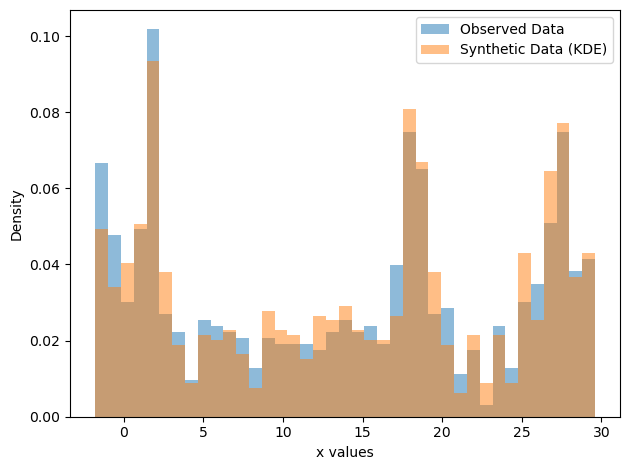

In [3]:
# Load observed data (we are interested in SST values)
df = load_tierney2015(as_frame=True).frame
# display(df)
observed_x = df["SST"].values

# Initialise random number generator
rng = np.random.default_rng(1234)

# some parameters
# for plotting histogram
BINS = len(df)//20
RANGE = (min(observed_x),max(observed_x))
# and for sampling the synthetic data (for the independent variable)
p = 1.0
N_OBS = int(len(df)*p)
SAMPLING = "as_linear"
SAMPLING = "as_observed"
X_SIGMA = 2.5

OUTLIER_FRACTION = 0

if SAMPLING == "as_observed":
    # Create a synthetic distribution using observed data
    # Use KDE to approximate the distribution
    kde = st.gaussian_kde(observed_x, bw_method=1/BINS)  # Fit KDE to the observed data
    synthetic_x_kde = kde.resample(size=1000, seed=rng).flatten()  # Generate synthetic data from KDE
    
    # Visualize the synthetic data
    fig, ax = plt.subplots(1,1)
    ax.hist(observed_x, bins=BINS, range=RANGE, density=True, alpha=0.5, label="Observed Data")
    ax.hist(synthetic_x_kde, bins=BINS, range=RANGE, density=True, alpha=0.5, label="Synthetic Data (KDE)")
    ax.set_xlabel("x values")
    ax.set_ylabel("Density")
    ax.legend()
    fig.tight_layout()

if SAMPLING is "as_linear":
    # Evenly sampled (linear)
    Xmin = -2
    Xmax = 40
    X_true = np.linspace(Xmin,Xmax,N_OBS)
elif SAMPLING is "as_observed":
    # Unevenly sampled (from observed distribution)
    X_true = np.sort(kde.resample(size=N_OBS, seed=rng).flatten())
    Xmin = min(X_true)
    Xmax = max(X_true)

In [4]:
MODEL = "macromolecular_rate_theory"

params_dict = OrderedDict()
if MODEL is "logistic_curve":
    base_model        = logistic_curve
    params_dict["L"]  = np.array([ 20,  22, 90])
    params_dict["k"]  = np.array([0.08, 0.02, -0.15])
    params_dict["x0"] = np.array([15, 31, 0])
elif MODEL is "macromolecular_rate_theory":
    base_model            = macromolecular_rate_theory
    params_dict["x_opt"]   = np.array([-5,0,10])+273.15
    params_dict["x_range"] = np.array([20,30,25])
    params_dict["scale"]  = np.array([10,1,6])*10
    
our_model = partial(base_model, math_lib=np)
our_model_pymc = partial(base_model, math_lib=pm.math)

s = f" True synthetic model parameters for '{MODEL}': "
print(s)
print("".join(["="]*len(s)))
for k,v in params_dict.items():
    print(f"{k} = {v}")
print("".join(["="]*len(s)))
print(f"Sampling: '{SAMPLING}'")
print(f"{p = }")
print("".join(["="]*len(s)))

params = [v for k,v in params_dict.items()]

X = rng.normal(X_true,X_SIGMA) # this is the predictor we observe

alpha = our_model(X_true[:, None],*params)
print(alpha.shape)
A, B, C = np.array([rng.dirichlet(alpha=alpha[i,:]) for i in range(N_OBS)]).T # this is our observed Y.
# A, B = np.array([rng.dirichlet(alpha=alpha[i,:2]) for i in range(N_OBS)]).T # this is our observed Y.

# Create outliers
outlier_deltas = []
if OUTLIER_FRACTION > 0:
    outlier_ids = rng.choice(np.arange(N_OBS), size=int(N_OBS*OUTLIER_FRACTION), replace=False)
    outlier_set = rng.choice(range(3), size=int(N_OBS*OUTLIER_FRACTION), replace=True)
    # print(outlier_set)
    for i,s in zip(outlier_ids, outlier_set):
        outlier_delta = rng.lognormal(0,1)
        if s == 0:
            A[i] *= outlier_delta
        elif s == 1:
            B[i] *= outlier_delta
        elif s == 2:
            C[i] *= outlier_delta
        outlier_deltas.append(outlier_delta)
        
        # Re-normalize A, B, C to sum to 1
        total = A[i] + B[i] + C[i]
        A[i] /= total
        B[i] /= total
        C[i] /= total


 True synthetic model parameters for 'macromolecular_rate_theory': 
x_opt = [268.15 273.15 283.15]
x_range = [20 30 25]
scale = [100  10  60]
Sampling: 'as_observed'
p = 1.0
(781, 3)


## Visualize the synthetic data

We have chosen an example of three components because it's simple enough to put on a graph and complicated enough to show some interesting behaviour. 

We put put three components on a so-called ternary plot with the independent variable $x$ colour-coded.

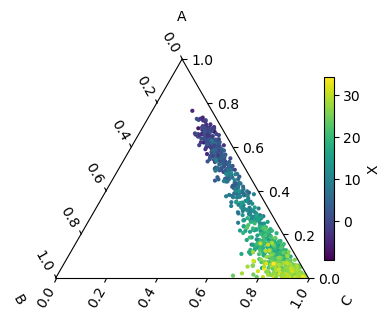

In [5]:
# Ternary plot of three species
fig, ax = plt.subplots(1,1,figsize=(4,4), subplot_kw={"projection": "ternary"})
# fig, ax = plt.subplots(1,1,figsize=(4,4))
pc = ax.scatter(A, B, C, c=X, marker='.',lw=0)
# ax.plot(X, A, marker='.',lw=0)
# ax.plot(X, B, marker='.',lw=0)
plt.colorbar(pc,ax=ax,shrink=0.5,label='X')
ax.set_tlabel('A')
ax.set_llabel('B')
ax.set_rlabel('C')

fig.tight_layout()
# fig.savefig(f"../reports/figures/dirichlet_example_synthetic_data.png",dpi=300,bbox_inches='tight', pad_inches = 0.01)

Alternatively, we can plot each component separately. The top row are the shape parameters and the bottom row are the individual components. In the bottom row you can see a dashed line. This is the mean (or expected) value of the proportions. It can be calculated from the three shape parameters:

$$
E[y] = \frac{\alpha_i}{\sum_i^N \alpha_i} \quad \text{with} \quad y \in \{A, B, C\}
$$

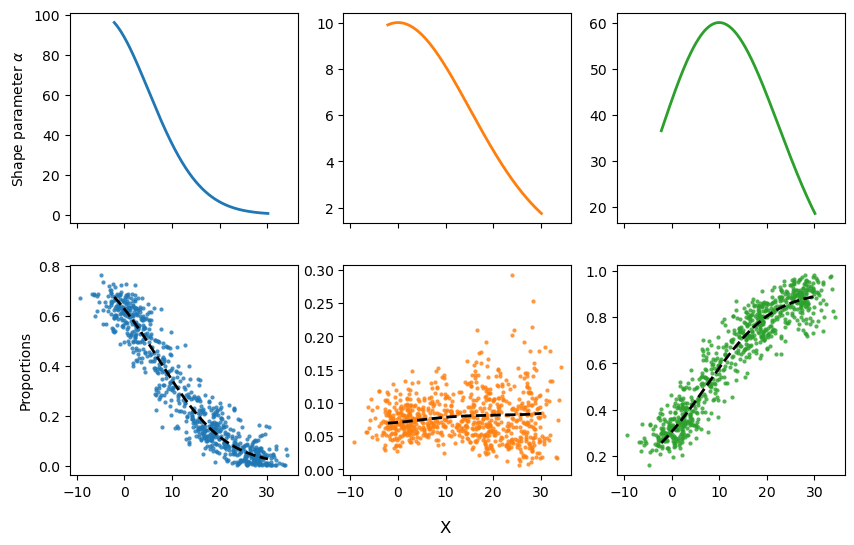

In [6]:
X_cont = np.linspace(Xmin,Xmax,1000)
# panel plots of logistic curves
fig, ax = plt.subplots(2,3, figsize=(10,6), sharex=True)
alpha_mean = []
for i in range(3):
    ax[0,i].plot(X_cont,our_model(X_cont,*[p[i] for p in params]), lw=2, c=f'C{i}')
    alpha_mean.append(our_model(np.sort(X_cont),*[p[i] for p in params]))

alpha_mean = np.array(alpha_mean)
alpha_mean /= alpha_mean.sum(axis=0)


for i,y in enumerate([A,B,C]):
    ax[1,i].plot(X, y, '.', c=f'C{i}', mew=0, alpha=0.8)
    ax[1,i].plot(X_cont, alpha_mean[i,:], 'k--', lw=2)

ax[1,0].set_ylabel("Proportions")
ax[0,0].set_ylabel(r"Shape parameter $\alpha$")
_ = fig.supxlabel("X")

# Bayesian Inference

OK. Let's define our probabilstic model for the Bayesian Inference. To do that we have to put a prior on every unknown (or unobserved) parameter (or variable, or data†). We  can build our (`pymc`, i.e., the Bayesian model) semi-automatically because we have designed a flexible model structure (see [Design Model(s)](#Design-Model(s))).

Most model parameters are drawn from a Normal distribution (some parameters have to be > 0, hence they are truncated), some are drawn from a LogNormal distribution, but nothing fancy, really.

And because we are working with synthetic data, we have "full" insight into the data, even into the ones we normally don't know anything about. For example, we know the true parameter values (check above for outputs after `True synthetic model parameters for ...`). We also knw the true independent variable `X_true`. In our `pymc` model, we want to model that and retrieve it later from the model. That's why variables we want to check later have names, such as our random variable `"X_true"`, as in line 

```
X_true_ = pm.Normal("X_true", mu=np.nanmean(X), sigma=np.nanstd(X), dims=("obs"))
```

The graph of the model is a good visual representation of what's going on in the model, but also a true graph in the mathematical sense. 

†: Parameter and variable can be used interchangeably (data is actually also also just a variable). They are technically the same ("parameter" = "unobserved variable").

In [7]:
N_SAMPLES = 100

combined_indices = np.arange(N_OBS)
compound_names = ["A", "B", "C"]
# compound_names = ["A", "B"]

coords = {
    "obs": combined_indices,
    "compound": compound_names,
}

y = np.stack([A,B,C]).T
# y = np.stack([A,B]).T
print(y.shape)

INFERENCE_MODEL = MODEL
# INFERENCE_MODEL = "no_model"
# our_model_pymc = partial(no_model, math_lib=pm.math)

IS_MODEL = INFERENCE_MODEL != "no_model"

with pm.Model(coords=coords) as model:
    X_data = pm.Data("X_data", X, dims=("obs"))
    y_data = pm.Data("y_data", y, dims=("obs","compound"))

    # priors for model parameters
    pt_params = OrderedDict()
    if INFERENCE_MODEL is "logistic_curve":
        L_mean_prior = 20
        L_sigma      = 5
        pt_params["L"]  = pm.TruncatedNormal("L", mu=L_mean_prior, sigma=L_sigma, lower=0, dims="compound")
        pt_params["k"]  = pm.Normal("k", mu=0, sigma=0.1, dims="compound")
        pt_params["x0"] = pm.Normal("x0", mu=0, sigma=5, dims="compound")
    elif INFERENCE_MODEL is "macromolecular_rate_theory":
        pt_params["x_opt"] = pm.Normal("x_opt", mu=params_dict["x_opt"].mean(), sigma=params_dict["x_opt"].std(), dims=("compound"))
        pt_params["x_range"] = pm.Normal("x_range", mu=params_dict["x_range"].mean(), sigma=params_dict["x_range"].std(), dims=("compound"))
        pt_params["scale"] = pm.TruncatedNormal("scale", mu=params_dict["scale"].mean(), sigma=params_dict["scale"].std(), lower=0, dims=("compound"))
    elif INFERENCE_MODEL == "no_model":
        print(f"{np.log(alpha).mean() = }")
        print(f"{np.log(alpha).std() = }")
        # a_mean = np.log(alpha).mean()#pm.Normal("a_mean", mu=2, sigma=2)
        # a_sigma = pm.HalfNormal("a_sigma", sigma=1)
        a_mean  = pm.Normal("a_mean", mu=np.log(alpha).mean(), sigma=np.log(alpha).std())
        pt_params["a"]    = pm.LogNormal("a", mu=a_mean, sigma=1, dims=("obs","compound"))
        # pt_params["a"]    = pm.Uniform("a", lower=0, upper=alpha.max(), dims=("obs","compound"))
        # print(pt_params["a"].eval().mean())
    for k,v in pt_params.items():
        print(f"{k}: {v.eval()}")
    # priors for independent variable
    X_true_ = pm.Normal("X_true", mu=np.nanmean(X), sigma=np.nanstd(X), dims=("obs"))
    # X_true_ = pm.Uniform("X_true", lower=np.nanmin(X), upper=np.nanmax(X), dims=("obs"))
    X_sigma_ = pm.HalfNormal("X_sigma", sigma=10)
    # X_sigma_ = X_SIGMA
    X_ = pm.Normal("X", mu=X_true_, sigma=X_sigma_, observed=X_data, dims=("obs"))

    # Likelihoods
    a_ = pm.Deterministic(INFERENCE_MODEL, our_model_pymc(X_true_[:,None],*[v for _,v in pt_params.items()]))
    y_ = pm.Dirichlet("y", a=a_, observed=y_data, dims=("obs","compound"))
    # print(f"{y_.eval().shape = }")    
    
    # Sample from prior
    trace = pm.sample_prior_predictive(samples=N_SAMPLES)

(781, 3)
x_opt: [265.63680572 274.06019588 272.01969064]
x_range: [24.97596077 20.45391831 26.4630453 ]
scale: [ 21.11427818  25.77565335 117.71145959]


Sampling: [X, X_sigma, X_true, scale, x_opt, x_range, y]


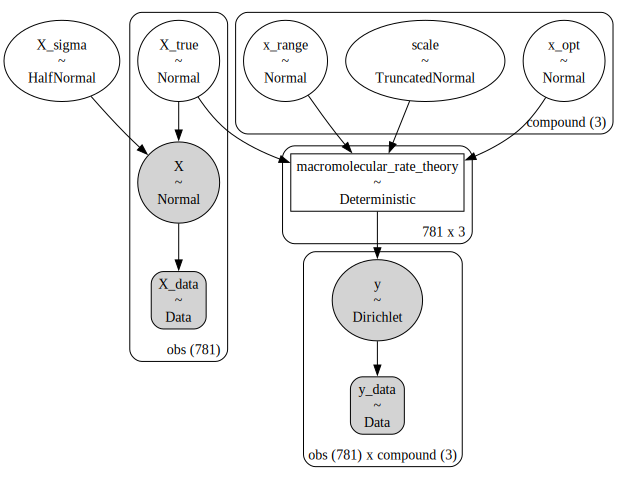

In [8]:
gv = pm.model_to_graphviz(model)
gv

In [9]:
model.free_RVs

[x_opt ~ Normal(275, 6.24),
 x_range ~ Normal(25, 4.08),
 scale ~ TruncatedNormal(56.7, 36.8, 0, inf),
 X_true ~ Normal(13.4, 10.5),
 X_sigma ~ HalfNormal(0, 10)]

## Model inspection (Part I)

We can inspect our model already before running the inference. That's a good thing because we can check if there is something odd about our model.

For example, we can plot the observed data (as kernel density estimates (KDEs); a smoothed histogram, basically) overlaid on prior predictive KDEs, for `X`, our independent variable, and `y`, our observed data. Here, our approach may be different from other Bayesian approaches: We try to estimate the likelihoods of both, inputs and outputs. Usually, one would want to estimate the likelihoods on some know inputs. However, our ultimate goal is to predict both based on observations for our outputs (i.e., `y`) but not necessarily inputs. Too complicated? In know... and I'm sorry.

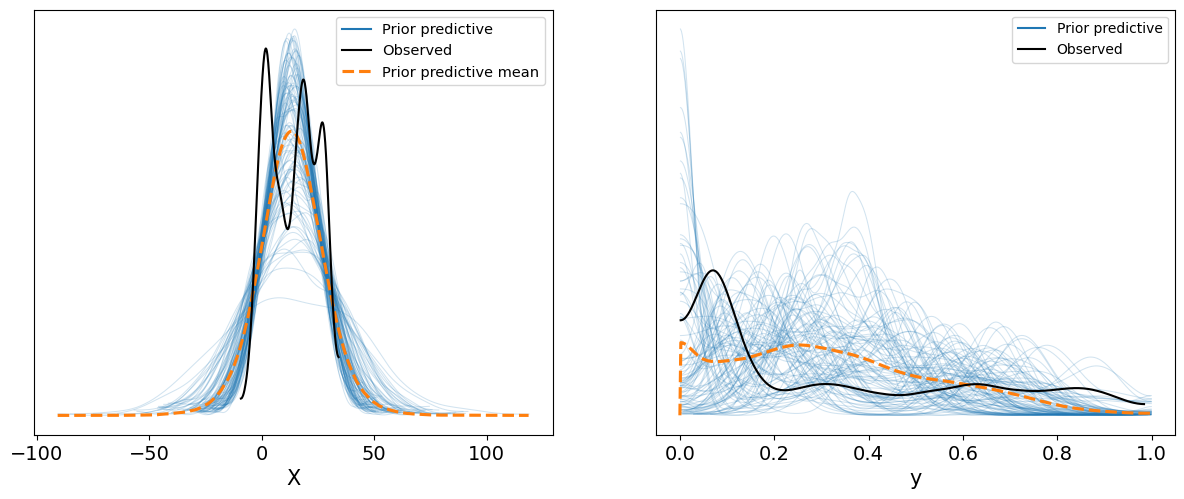

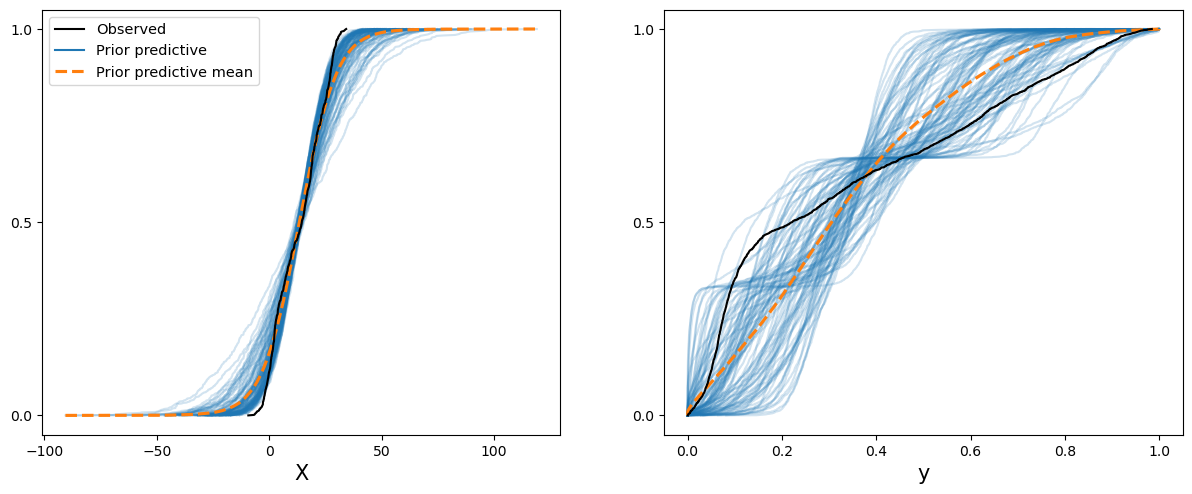

In [10]:
ax = az.plot_ppc(trace, group='prior', observed=True)

ax = az.plot_ppc(trace, group='prior', observed=True, kind='cumulative')

Here's another model diagnostic: We can look into the functional forms of the shape parameters $\alpha$ for our three components. Again, because we have full insights into our synthetic data, we know the "true" functional form for each (dashed lines). In a real-world scenario we wouldn't and we would have to make a good guess.

In [11]:
def plot_functional_form(stack,logscale=False):
    fig, ax = plt.subplots(1,3, figsize=(9,3), sharex=True)
    
    N_TOTAL = len(stack["samples"])
    
    for n in tqdm(rng.choice(range(N_TOTAL), size=500)):
        params_p = np.array([stack[k].isel(samples=n).values for k in pt_params.keys()])
        for i in range(3):
            ax[i].plot(X_cont,our_model(X_cont,*[p[i] for p in params_p]), lw=1, alpha=0.1, c=f'C{i}')
            
    for i in range(3):
        ax[i].plot(X_cont,our_model(X_cont,*[p[i] for p in params]), 'k--')
        if logscale:
            ax[i].set_yscale("log")
    fig.supxlabel("X")
    fig.supylabel(r"$\alpha$")
    fig.tight_layout()
    return fig, ax

  0%|          | 0/500 [00:00<?, ?it/s]

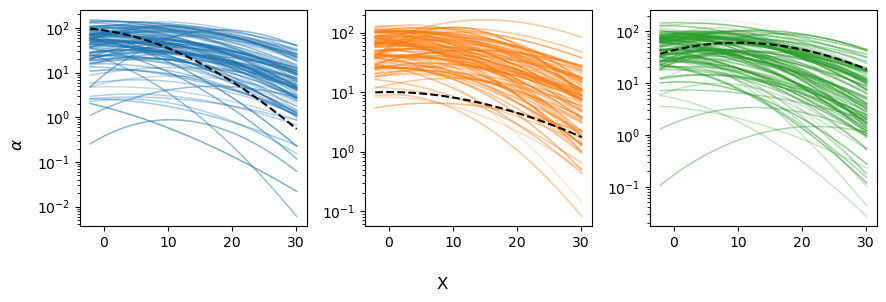

In [12]:
if IS_MODEL:
    fig, ax = plot_functional_form(trace.prior.stack(samples=("chain","draw")),logscale=True)

OK. Now let's compute the posterior distributions for the unknown data (or parameters). BTW, the cell output while running the model is awesome (you can watch what's going on and that's what we want).

In [13]:
# posterior (MCMC) sampling
with model:
    trace.extend(pm.sample())

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_opt, x_range, scale, X_true, X_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 114 seconds.


## Model inspection (Part II)

Let's look at the trace of the inference. That's basically the posterior distribution of our unknown variables (= parameters = data, remember?).

The gray vertical lines are the true model paramaters. See you close they are to the peaks of the posterior distributions? This means that we can infer a range of plausible values and our approach works. 

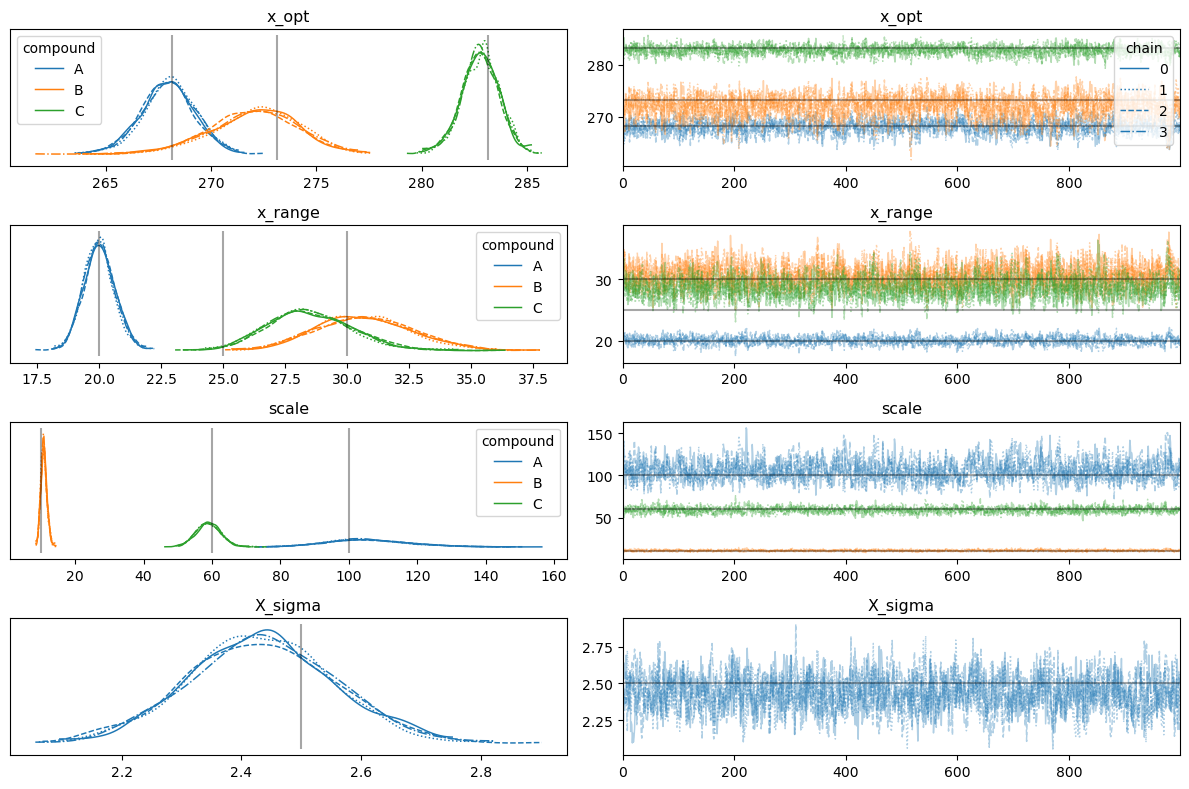

In [14]:
var_names = ["~X_true", f"~{INFERENCE_MODEL}"] # exclude the independent and dependent variables because that's a lot to look at
true_param_lines = [(k, {}, v) for k,v in params_dict.items()]
true_param_lines += [("X_sigma", {}, X_SIGMA)]

if IS_MODEL:
    ax = az.plot_trace(trace,var_names=var_names, lines=true_param_lines, legend=True)
    plt.tight_layout()

In [15]:
with model:
    trace.extend(pm.sample_posterior_predictive(trace))

Sampling: [X, y]


Output()

We can also directly look into the `trace` object. It's an `xarray` dataset. Very neat for inspection or for saving it to file.

In [16]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Let's have a look at the KDEs, as we did for the prior predictive, but now for the posterior predictive. That's why we had to run `pm.sample_posterior_predictive(trace)` a few cells above. The observational data are hardly distinguishable from the predicited data for the CDF version of the diagnostics.

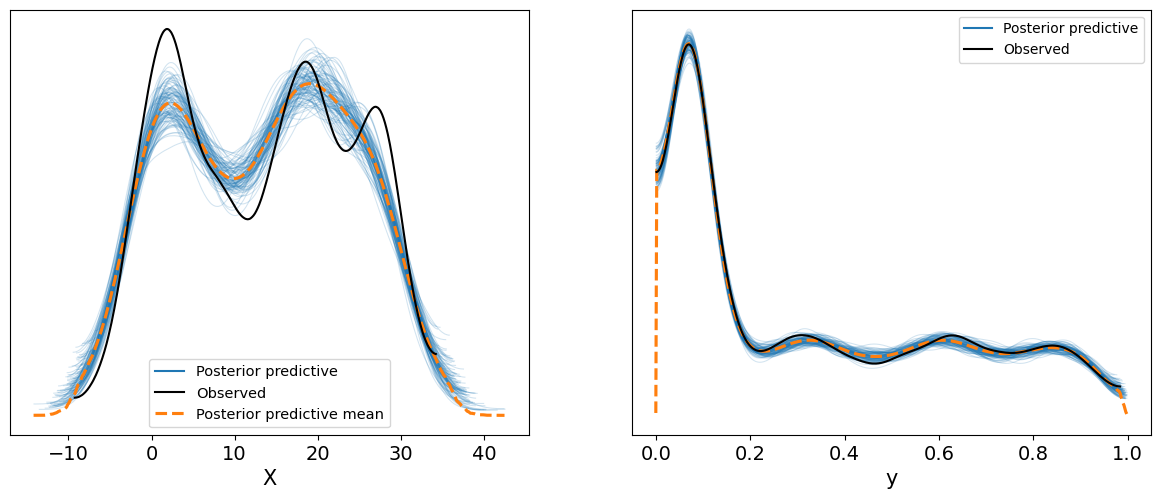

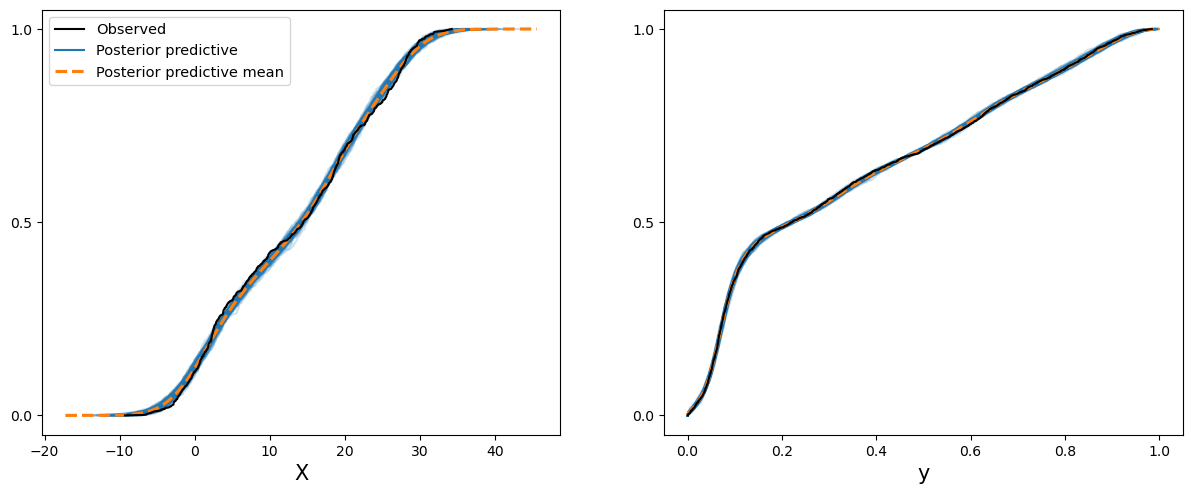

In [17]:
ax = az.plot_ppc(trace, num_pp_samples=100)

ax = az.plot_ppc(trace, num_pp_samples=100, kind='cumulative')

## Model inspection (Part III)

We can directly compare our predicted variables with the true synthetic (observed?) ones. The graph below shows the mean estimated predictions (it's probabilistic, remember?) for the independent variable `X` compared to the true `X`. The gray shaded area is the area of the so-called high density interval: 94% of individual estimates or draws fall within this area.

We can also calculate the root mean squared error (`rmse`) for all estimates (4 time 1,000 times number of datapoints, in total).

(4, 1000, 781)
rmse = 2.28


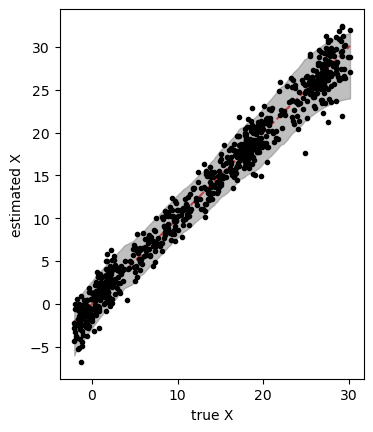

In [18]:
X_true_p = trace.posterior["X_true"].stack(samples=("chain","draw")).mean("samples")
print(trace.posterior["X_true"].shape)

fig, ax = plt.subplots(1,1)
ax.plot(X_true, X_true_p, 'k.')
ax.plot([min(X_true),max(X_true)], [min(X_true),max(X_true)], 'r--', zorder=-5)
az.plot_hdi(X_true, trace.posterior["X_true"],color='gray',ax=ax)
ax.set_aspect("equal")
ax.set_xlabel("true X")
ax.set_ylabel("estimated X")

rmse = (((trace.posterior["X_true"]-X_true)**2).mean())**0.5
print(f"{rmse = :.2f}")

## Model inspection (Part IV)

We can take these inferred estimates and put them back onto the ternary plot from the beginning. Shown are two samples from the posterior predicitve distribution. They highlight how good our inference is: The true data is hardly distinguishable from any of the two samples; they look indeed very similar.

Bonus point for the inferred estimates: We can calculate the mean proportions from all samples (the circles with the black outlines), whereas our synthetic dataset just represents a single realisation of a process.

(781, 3)
(781, 3)


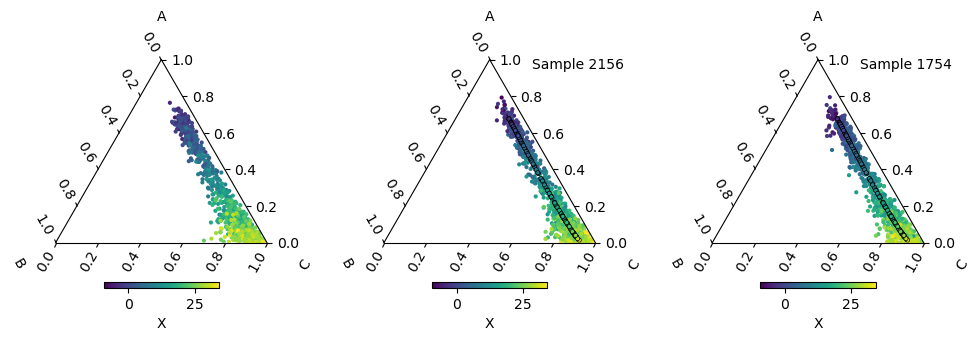

In [19]:
stacked = trace.stack(samples=("chain","draw"))
y_pred_mean = stacked.posterior_predictive["y"].mean("samples")
X_pred_mean = stacked.posterior_predictive["X"].mean("samples")

N_pp = 2
fig, ax = plt.subplots(1,1+N_pp,subplot_kw={"projection": "ternary"},figsize=(10,3.5))

vmin=min(X)
vmax=max(X)
pc = ax[0].scatter(A, B, C, c=X, vmin=vmin, vmax=vmax, marker='.', lw=0)

for i,s in enumerate(rng.choice(len(stacked.posterior_predictive.samples),2)):
    y_pred = stacked.posterior_predictive["y"].isel(samples=s)
    X_pred = stacked.posterior_predictive["X"].isel(samples=s)
    print(y_pred.shape)
    pc = ax[1+i].scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], c=X_pred, vmin=vmin, vmax=vmax, marker='.',lw=0)
    inc = 5
    ax[1+i].scatter(y_pred_mean[::inc,0], y_pred_mean[::inc,1], y_pred_mean[::inc,2], c=X_pred_mean[::inc], vmin=vmin, vmax=vmax, marker='.',lw=0.5, edgecolors='k')
    ax[1+i].text(0.7,0.95,f"Sample {s}",transform=ax[1+i].transAxes)

for a in ax:
    plt.colorbar(pc,ax=a,orientation="horizontal", shrink=0.5,label='X')
    a.set_tlabel('A')
    a.set_llabel('B')
    a.set_rlabel('C')

fig.tight_layout()

(4, 1000, 781, 3)


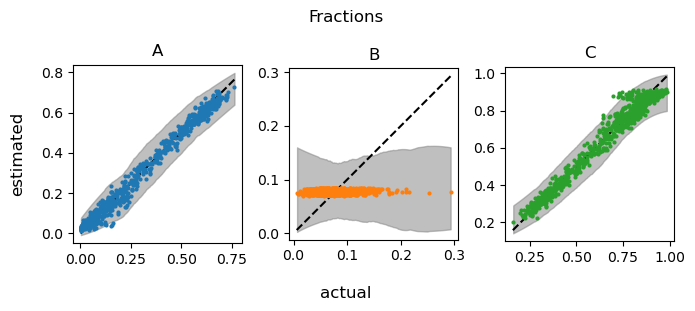

In [20]:
y_p = trace.posterior_predictive["y"].stack(samples=("chain","draw")).mean("samples").values
print(trace.posterior_predictive["y"].shape)

fig, ax = plt.subplots(1,3,figsize=(7,3))#sharex=True,sharey=True)

for i in range(3):
    ax[i].plot([min(y[:,i]),max(y[:,i])],[min(y[:,i]),max(y[:,i])],'k--')
    ax[i].plot(y[:,i], y_p[:,i], ls='', marker='.', mew=0, color=f"C{i}")
    az.plot_hdi(y[:,i], trace.posterior_predictive["y"].sel(compound=compound_names[i]), color='gray', ax=ax[i])
    ax[i].set_aspect("equal")
    ax[i].set_title(compound_names[i])


fig.suptitle("Fractions")
fig.supxlabel("actual")
fig.supylabel("estimated")

fig.tight_layout()

In [21]:
if not IS_MODEL:
    alpha_p = trace.posterior["a"].stack(samples=("chain","draw")).mean("samples").values
    print(trace.posterior["a"].shape)
    
    fig, ax = plt.subplots(1,2,figsize=(5,3))#,sharex=True,sharey=True)
    
    for i in range(2):
        ax[i].plot([min(alpha[:,i]),max(alpha[:,i])],[min(alpha[:,i]),max(alpha[:,i])],'k--')
        ax[i].plot(alpha[:,i], alpha_p[:,i], ls='', marker='.', mew=0, color=f"C{i}")
        az.plot_hdi(alpha[:,i], trace.posterior["a"].sel(compound=compound_names[i]), color='gray', ax=ax[i])
        ax[i].set_title(compound_names[i])
    
    fig.suptitle("Shape parameters")
    fig.supxlabel("actual (mean)")
    fig.supylabel("estimated")
    
    fig.tight_layout()

We can look at the functional forms again. This time for the posterior model values. They do a good job at capturing the functional relationship between inputs.

  0%|          | 0/500 [00:00<?, ?it/s]

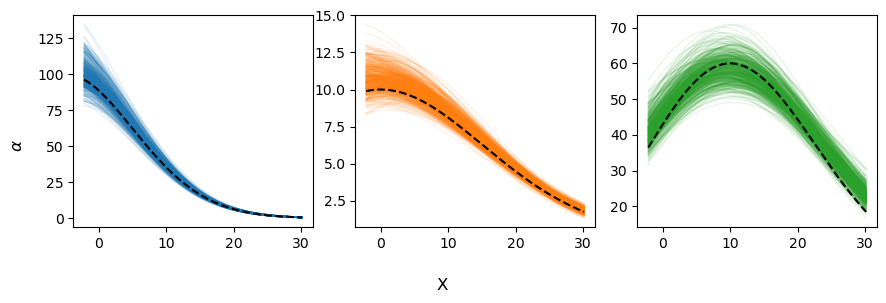

In [22]:
if IS_MODEL:
    fig, ax = plot_functional_form(stacked.posterior)

# Make predictions

Let's make predictions for unobserved `X_true`. We are building a similar but slightly different model as before. This time, we want to use the posteriors from the previous inference to inform our model for unknown `X_true`. Of course, we always treat the output, i.e., the proportions of A, B, and C, as likelihoods and model them accordingly.

We can look at this predictive version of our Bayesian model graphically. At this stage, we don't need to know what the object `trace_prior_` is coming out of the method `prior_from_idata(...)`.

In [23]:
N_OBS_TEST = 100
X_true_test = rng.uniform(low=Xmin,high=Xmax,size=N_OBS_TEST)

alpha_test = our_model(X_true_test[:, None],*params)
A_test, B_test, C_test = np.array([rng.dirichlet(alpha=alpha_test[i,:]) for i in range(N_OBS_TEST)]).T

combined_indices = np.arange(N_OBS_TEST)
compound_names = ["A", "B", "C"]

coords = {
    "obs": combined_indices,
    "compound": compound_names,
}

y_test = np.stack([A_test,B_test,C_test]).T
print(y_test.shape)

with pm.Model(coords=coords) as model_pred:
    y_data = pm.Data("y_data", y_test, dims=("obs","compound"))
    
    # priors for model parameters
    pt_params_pred = prior_from_idata(
        trace,
        var_names = list(pt_params.keys()) + ["X_sigma"],
        # **pt_params_transforms,
    )
    # priors for independent variable
    X_true_ = pm.Normal("X_true", mu=np.nanmean(X), sigma=np.nanstd(X), dims=("obs"))
    # X_sigma_ = pm.HalfNormal("X_sigma", sigma=1)
    X_sigma_ = pt_params_pred["X_sigma"]
    X_ = pm.Normal("X", mu=X_true_, sigma=X_sigma_, dims=("obs"))

    # Likelihoods
    a_ = our_model_pymc(X_true_[:,None],*[pt_params_pred[k] for k in pt_params.keys()])
    y_ = pm.Dirichlet("y", a=a_, observed=y_data, dims=("obs","compound"))
    print(f"{y_.eval().shape = }")

(100, 3)
y_.eval().shape = (100, 3)


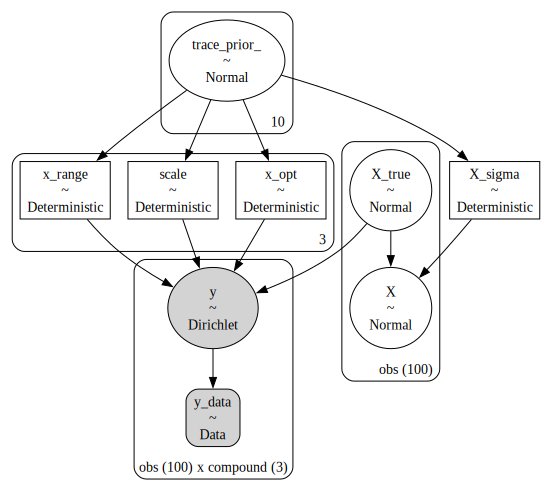

In [24]:
gv = pm.model_to_graphviz(model_pred)
gv

The rest follows the same procedure as before: We estimate the posterior distribution of unobserved variable. Then, we make predictions and compare them to the true values from our synthetic data sets.

In [25]:
with model_pred:
    trace_pred = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [trace_prior_, X_true, X]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


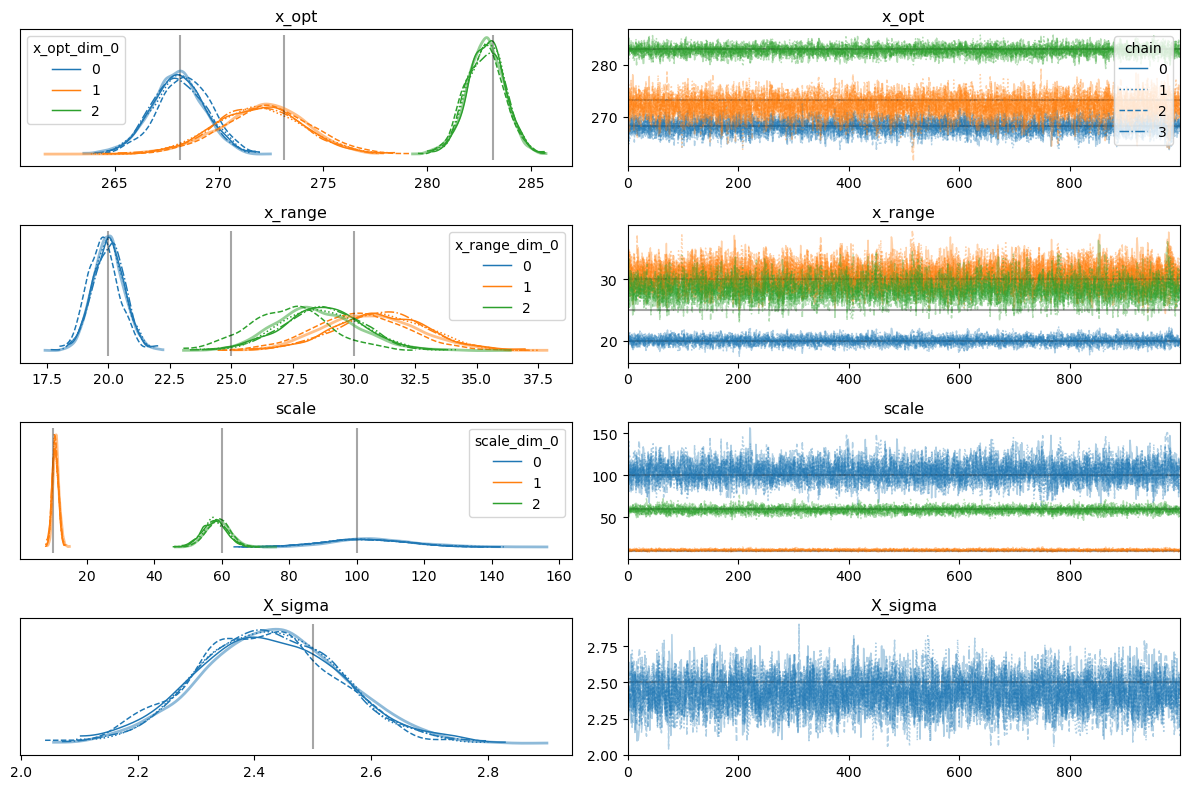

In [26]:
true_param_lines = [(k, {}, v) for k,v in params_dict.items()]
true_param_lines += [("X_sigma", {}, X_SIGMA)]

if IS_MODEL:
    ax = az.plot_trace(trace_pred,var_names=var_names+["~trace_prior_","~X"], lines=true_param_lines, legend=True)
    az.plot_trace(trace,var_names=var_names+["~trace_prior_","~X"],combined=True, axes=ax, plot_kwargs={'lw': 2, 'alpha': 0.5})#, colors='k', ls='--')
    plt.tight_layout()

In [27]:
with model_pred:
    trace_pred.extend(pm.sample_posterior_predictive(trace_pred))

Sampling: [y]


Output()

array([<Axes: xlabel='y'>], dtype=object)

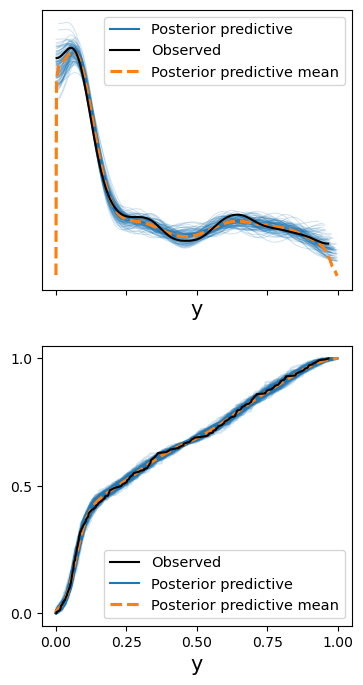

In [28]:
fig, ax = plt.subplots(2,1, figsize=(4,8), sharex=True)

az.plot_ppc(trace_pred, num_pp_samples=100, ax=ax[0])
az.plot_ppc(trace_pred, num_pp_samples=100, kind='cumulative', ax=ax[1])

Final check how the true values of `X` compare to the estimated ones, this time without observations to condition them on.

rmse_pred = 3.65


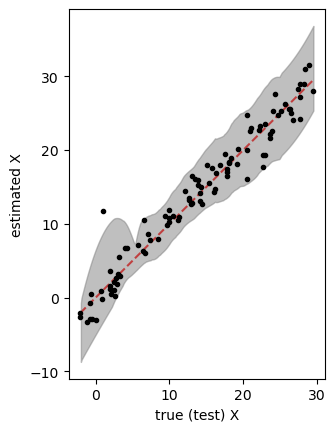

In [29]:
X_true_test_p = trace_pred.posterior["X_true"].stack(samples=("chain","draw")).mean("samples")

fig, ax = plt.subplots(1,1)
ax.plot(X_true_test, X_true_test_p, 'k.')
ax.plot([min(X_true_test),max(X_true_test)], [min(X_true_test),max(X_true_test)], 'r--', zorder=-5)
az.plot_hdi(X_true_test, trace_pred.posterior["X_true"],color='gray',ax=ax)
ax.set_aspect("equal")
ax.set_xlabel("true (test) X")
ax.set_ylabel("estimated X")

rmse_pred = (((trace_pred.posterior["X_true"]-X_true_test)**2).mean())**0.5
print(f"{rmse_pred = :.2f}")

In [30]:
%watermark
%watermark -iv

Last updated: 2025-03-25T15:11:09.889872+13:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 9.0.2

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

arviz      : 0.21.0
tqdm       : 4.67.1
numpy      : 2.2.4
sys        : 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:25:12) [Clang 18.1.8 ]
mpltern    : 0.0.0
matplotlib : 3.10.1
scipy      : 1.15.2
pandas     : 2.2.3
pymc       : 5.21.1
pymc_extras: 0.2.4

